In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from scipy.special import expit
from mobilenet import mobilenet_v1
from preprocessing import preprocessing_factory
from scipy.ndimage import imread
preprocessing = preprocessing_factory.get_preprocessing('mobilenet_v1')
CLASS_OF_INTEREST = 10
EPS = 0.1
sess = tf.Session()

In [2]:
fw = tf.summary.FileWriter('./log', sess.graph)

## Get some pretrained tensorflow network for our needs

10 класс это страус.

11 класс это птичка.


$y = f(x)$, where y - prediction, $f(\cdot)$ - NN, x - image(for example)

In [3]:
arr = imread('./brambling.jpg')
img = preprocessing(tf.Variable(arr, dtype=tf.float32) / 255, output_height=224, output_width=224)

/home/acappello/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


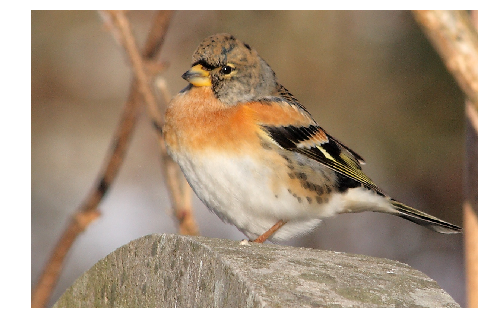

In [4]:
plt.imshow(arr);
plt.axis('off')
plt.show();

Инициализируем переменные, которые нам понадобятся.

Сейчас инициализируем картинкой птички.

In [5]:
D = 224 * 224 * 3
#theta = tf.Variable(tf.random_uniform([224, 224, 3], minval=-1., maxval=1.), name="theta", trainable=True) # noise init
#theta = tf.Variable(img, name="theta") # bird init
theta = tf.Variable(tf.zeros([224, 224, 3]), name="theta", trainable=True) # noise init
mu = tf.constant([0.] * D)
diag_stdev = tf.placeholder_with_default(input=[0.01] * D, name='diag_stdev', shape=[D])
p_dist = tf.contrib.distributions.MultivariateNormalDiag(mu, diag_stdev)
diag_stdev_reshaped = tf.reshape(diag_stdev, shape=[224, 224, 3])
p = tf.Variable(tf.reshape(p_dist.sample(), [224, 224, 3]), name="p")

Загружаем веса сетки

In [6]:
with tf.contrib.slim.arg_scope(mobilenet_v1.mobilenet_v1_arg_scope()):
    logits, net = mobilenet_v1.mobilenet_v1(tf.expand_dims(theta, axis=0), is_training=False, num_classes=1001)
    
init_fn = tf.contrib.slim.assign_from_checkpoint_fn('./mobilenet/mobilenet_v1_1.0_224.ckpt', 
                                                        tf.contrib.slim.get_model_variables())

In [7]:
theta_old = tf.Variable(tf.zeros([224, 224, 3]), name="theta_old")
p_old = tf.Variable(tf.zeros([224, 224, 3]), name="p_old")

$log\_joint$ -- нечто вроде $\log(p)$

In [8]:
classifier = tf.sigmoid(logits)[:, CLASS_OF_INTEREST][0]
scale = tf.placeholder_with_default(input=-1., name='scale', shape=[])
smoothness = tf.placeholder_with_default(input=0.0001, name='smoothness', shape=[])
log_joint = scale * logits[:, CLASS_OF_INTEREST][0] + tf.image.total_variation(theta) * smoothness
#dist = tf.contrib.distributions.Normal(tf.zeros_like(theta), tf.ones_like(theta) / 5)
#log_joint = -tf.reduce_mean(tf.log(dist.prob(theta)))
# p(x) ~ exp(10 * (y - 1 + eps))
step = tf.placeholder_with_default(input=.001, name='step', shape=[])

## Minimization

Some code to do simple minimization.
Works fast but result is still miningless(unfortunatelly).

### Функция для шага алгоритма

In [9]:
def train_step(theta, p, p_old, theta_old, log_joint, L):
    assign_ops = []
    # calc H at the beginning
    H_old = log_joint + tf.reduce_sum(p**2 / diag_stdev_reshaped) / 2.

    # save old
    p_old_assigned = p_old.assign(p); # assign_ops.append(p_old_assigned)
    theta_old_assigned = theta_old.assign(theta); # assign_ops.append(theta_old_assigned)

    # draw impulse from normal distribution
    with tf.control_dependencies([H_old, p_old_assigned]):
        p_assigned = p.assign(tf.reshape(p_dist.sample(), [224, 224, 3])); # assign_ops.append(p_assigned)
    
    # integration leap frog step
    with tf.control_dependencies([p_assigned]):
        p_assigned = p.assign_add(-step * tf.gradients(log_joint, theta)[0] / 2.); # assign_ops.append(p_assigned)
    
    for i in range(L):
        with tf.control_dependencies([p_assigned, theta_old_assigned]):
            theta_assigned = theta.assign_add(step * p / diag_stdev_reshaped); # assign_ops.append(theta_assigned)
        if i != L - 1:
            with tf.control_dependencies([theta_assigned]):
                p_assigned = p.assign_add(-step * tf.gradients(log_joint, theta)[0] / 2.); # assign_ops.append(p_assigned)
            
    with tf.control_dependencies([theta_assigned]):
        p_assigned = p.assign_add(-step * tf.gradients(log_joint, theta)[0] / 2.); # assign_ops.append(p_assigned)
    
    # new H
    with tf.control_dependencies([p_assigned, theta_assigned]):
        H_new = log_joint + tf.reduce_sum(p**2 / diag_stdev_reshaped) / 2
        p_assigned = p.assign(-p)
    
    with tf.control_dependencies([p_old_assigned, theta_old_assigned, p_assigned, H_new]):
        alpha = tf.minimum(1., tf.exp(H_old - H_new))
        p_order = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
        pred = tf.less(p_order, alpha)
        assign_ops.append(tf.cond(pred, lambda: p.assign(p), lambda: p.assign(p_old)))
        assign_ops.append(tf.cond(pred, lambda: tf.clip_by_value(theta.assign(theta), -1, 1), lambda: theta.assign(theta_old)))
    return assign_ops + [alpha]

In [10]:
train_step_op = train_step(log_joint=log_joint, theta=theta, p=p, p_old=p_old, theta_old=theta_old, L=4)

In [11]:
init = tf.global_variables_initializer()
init.run(session=sess)
init_fn(sess)

INFO:tensorflow:Restoring parameters from ./mobilenet/mobilenet_v1_1.0_224.ckpt


Проверяем вероятности. Всё хорошо, это действительно птичка(1.0 вероятность), а не страус(p=0.123).

In [12]:
print("Probability of class 10:", sess.run(classifier))
print("Probability of class 11:", expit(sess.run(logits)[0][11]))

Probability of class 10: 0.194589
Probability of class 11: 0.604903


## 100 iterations of HMC

In [13]:
feed_dict = {
    diag_stdev: [0.001] * D, # params of the noise in HMC
    step: 0.00001, # step f integration
    scale: -10, # weight of cost function
    smoothness: 0. # weitght of smoothness term
}
init.run(session=sess, feed_dict=feed_dict)
init_fn(sess)

INFO:tensorflow:Restoring parameters from ./mobilenet/mobilenet_v1_1.0_224.ckpt


In [16]:
sess.run([tf.image.total_variation(theta), tf.image.total_variation(img)], feed_dict=feed_dict)

[0.0, 18263.328]

In [17]:
sess.run([log_joint], feed_dict=feed_dict)

[14.204643]

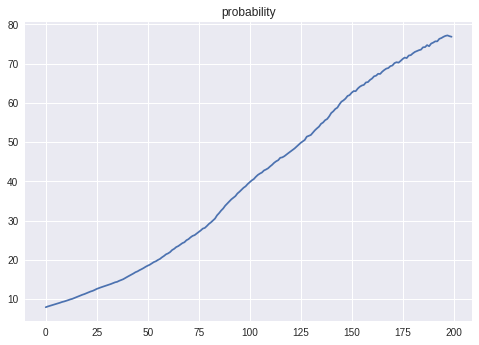

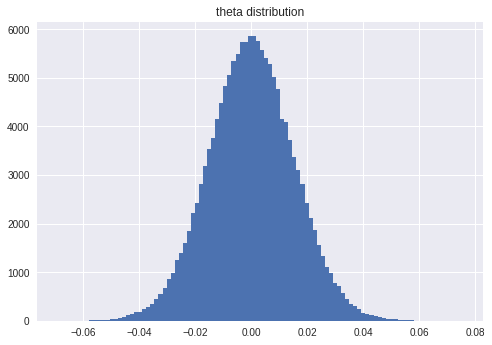

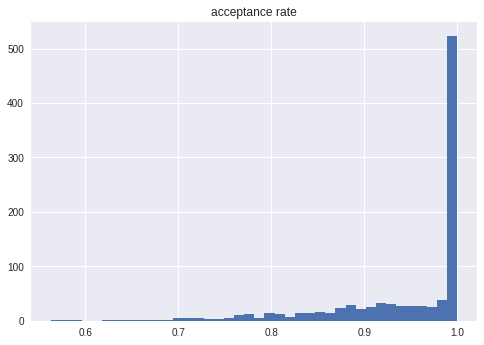

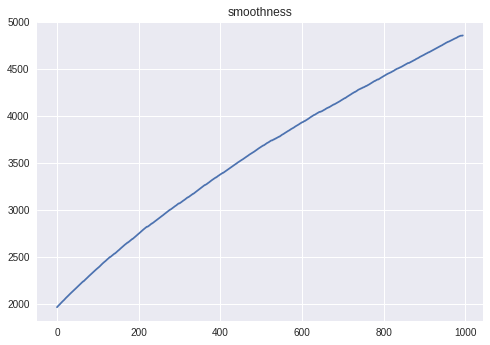

100%|██████████| 1000/1000 [25:34<00:00,  1.78s/it]


In [39]:
import tqdm
from IPython.display import clear_output
theta_samples = []
p_samples = []
H_samples = []
proba_samples = []
grad_sum_samples = []
reject_rate_samples = []
smoothness_samples = []
N = 1000
feed_dict = {
    diag_stdev: [0.0001] * D, 
    step: 0.0001,
    scale: -1,
    smoothness: 0.
}
for i in tqdm.tqdm(range(N)):
    if i % 5 == 0:
        clear_output()
        proba_samples.append(
            sess.run(logits[:, CLASS_OF_INTEREST][0], feed_dict=feed_dict)
        )
        plt.plot(proba_samples)
        plt.title('probability')
        plt.show()
        plt.hist(sess.run(theta, feed_dict=feed_dict).ravel(), bins=100);
        plt.title('theta distribution')
        plt.show()
        plt.hist(reject_rate_samples, bins=40);
        plt.title('acceptance rate')
        plt.show()
        plt.plot(smoothness_samples);
        plt.title('smoothness')
        plt.show()
    smoothness_samples.append(sess.run(tf.image.total_variation(theta), feed_dict=feed_dict))
    res = sess.run(train_step_op, feed_dict=feed_dict)
    reject_rate_samples.append(res[2])

In [40]:
fw.add_graph(sess.graph)
fw.flush()

### Теперь это и птичка и страус.

In [41]:
print("Probability of class 10:", sess.run(classifier))

Probability of class 10: 1.0


In [42]:
print("Probability of class 11:", expit(sess.run(logits)[0][11]))

Probability of class 11: 0.103238


In [43]:
pic = sess.run(theta)
old_pic = sess.run(img)

### Различие картинок буквально в отдельных пикселях и его ещё нужно заметить!

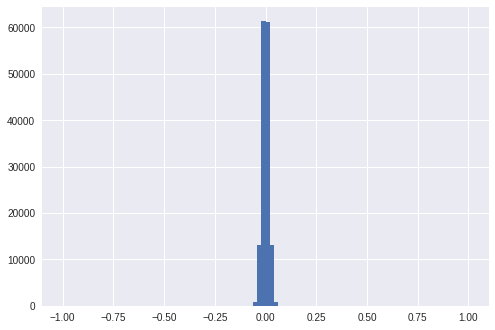

In [44]:
plt.hist(pic.ravel(), bins=100, range=(-1, 1));
plt.show();

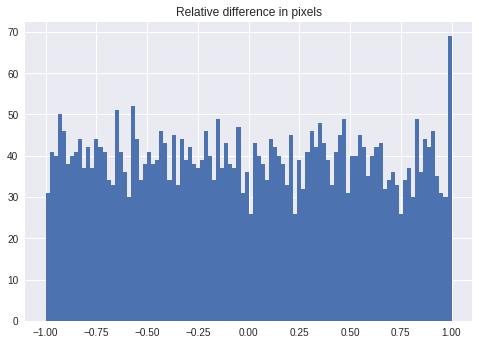

In [45]:
plt.hist(((pic - old_pic) / pic).ravel(), bins=100, range=(-1, 1));
plt.title('Relative difference in pixels')
plt.show();

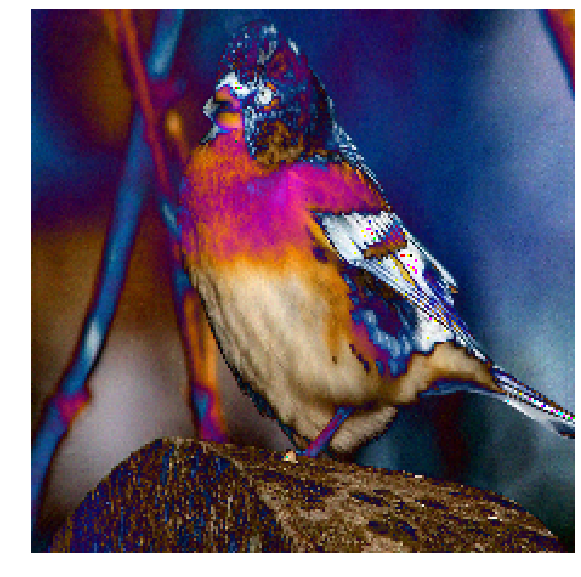

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(pic - old_pic));
plt.axis('off')
plt.show()

Картинка после Монте-Карло

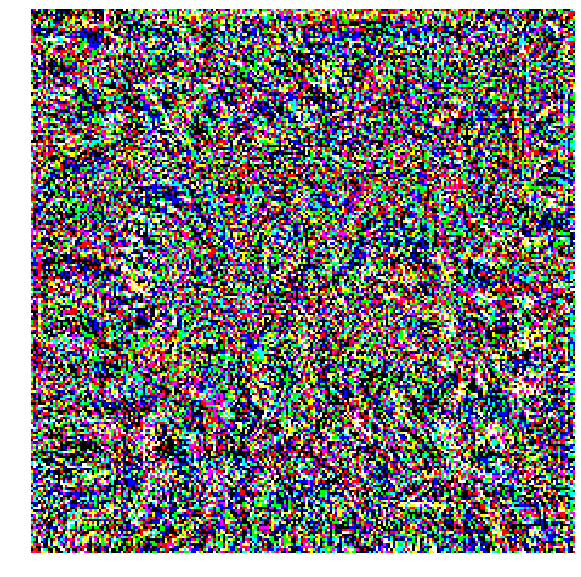

In [50]:
plt.figure(figsize=(10, 10))
plt.imshow(pic, interpolation='nearest')
plt.axis('off')
plt.show()

Картинка до Монте-Карло

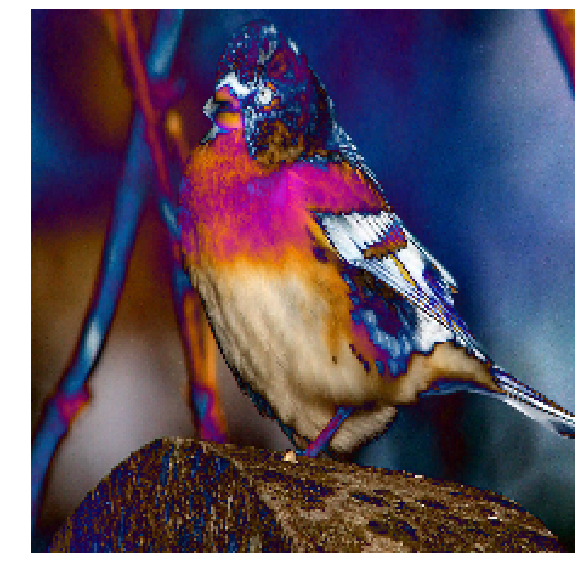

In [51]:
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(old_pic))
plt.axis('off')
plt.show()